In [1]:
import torch
import numpy as np

In [ ]:
#  This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
    #  Input:
    #       proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #       gt_labels: list:len(bz) {(n_obj)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #  Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
    #       labels: (total_proposals,1) (the class that the proposal is assigned)
    #       regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)

In [2]:
def IOU_vectorized(bboxes, anchors):
    ##################################
    # computes the IOU between the bounding boxes, anchors
    ##################################
    boxA = bboxes.reshape((1, bboxes.shape[0], bboxes.shape[1]))
    boxB = anchors.reshape((anchors.shape[0], 1, anchors.shape[1]))

    x1 = boxA[:,:,0]
    y1 = boxA[:,:,1]
    x2 = boxA[:,:,2]
    y2 = boxA[:,:,3]
    
    x3 = boxB[:,:,0]
    y3 = boxB[:,:,1]
    x4 = boxB[:,:,2]
    y4 = boxB[:,:,3]

    x1_int = np.maximum(x1, x3)
    y1_int = np.maximum(y1, y3)
    x2_int = np.minimum(x2, x4)
    y2_int = np.minimum(y2, y4)
    int_area = np.clip(x2_int - x1_int,0,None) * np.clip(y2_int - y1_int,0,None)
    u_area = (x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - int_area
    with np.errstate(divide='ignore'):
        iou = int_area / u_area
        iou[int_area == 0] = 0
    iou = iou.reshape((anchors.shape[0], bboxes.shape[0]))
    return torch.from_numpy(iou)

In [3]:
    def create_ground_truth(self,proposals,gt_labels,bbox):
        num_props = proposals[0].shape[0]
        bz = len(proposals)
        labels = np.zeros(num_props * bz)
        regressor_target = np.zeros((num_props * bz, 4))

        for i, (props, gt_boxes, g_labels) in enumerate(zip(proposals, bbox, gt_labels)):
            indices = torch.tensor([1,0,3,2]).to(props.device)
            props = torch.index_select(props, 1, indices)
            props = props.clone().cpu().numpy()
            iou_scores = IOU_vectorized(props, gt_boxes)
            iou_scores = np.where(iou_scores > 0.5, iou_scores, 0)
            max_iou_idx = np.argmax(iou_scores, axis=0)
            l = g_labels[max_iou_idx]
            sums = np.sum(iou_scores, axis=0)
            l[sums == 0] = 0
            labels[(i * num_props):((i+1)*num_props)] = l
            
            bboxes = gt_boxes[max_iou_idx]
            for j, (a, b) in enumerate(zip(props, bboxes)):
                xp, yp, wp, hp = (a[0]+a[2])/2, (a[1]+a[3])/2, a[2] - a[0], a[3] - a[1]
                x, y, w, h = (b[0]+b[2])/2, (b[1]+b[3])/2, b[2] - b[0], b[3] - b[1]
                tx = (x - xp)/wp
                ty = (y - yp)/hp
                tw = np.log(w/wp)
                th = np.log(h/hp)
                regressor_target[(i*num_props) + j] = [tx, ty, tw, th]

        return labels,regressor_target

In [4]:
# Fake Data
batch_size = 2
num_proposals = 5
proposals = np.array([[np.sort(np.random.random(4) * 20) for i in range(num_proposals)] for b in range(batch_size)])
ground_truth = np.array([[np.sort(np.random.random(4) * 20) for i in range(2)] for b in range(batch_size)])
gt_labels = [np.random.choice(np.arange(1,4),2) for b in range(batch_size)]

In [8]:
#Basic Initialization

#Code:
 #setting path in colab
 #mount the drive first
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
import os

#set the working directory 

root_dir = "/content/drive/My Drive/"

#choose the project folder
project_folder = "CIS680HW/HW4b/"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
  os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
  !touch 'new_file_test.txt'
  print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)

Mounted at /content/drive/
working directory/content/drive/My Drive/CIS680HW/HW4b/empty text file created. You can also run !pwd command to confirm working directory.


In [ ]:
cd /content/drive/MyDrive/CIS680HW/HW4b

/content/drive/MyDrive/CIS680HW/HW4b


In [9]:
from BoxHead import *
from utils import *
from dataset import BuildDataLoader, BuildDataset
from pretrained_models import pretrained_models_680
import torch.optim as optim
from torchvision.models.detection.image_list import ImageList
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.patches as patches

In [10]:
imgs_path = root_dir + 'CIS680HW' + '/HW3/data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = root_dir + 'CIS680HW'+'/HW3/data/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)

In [11]:
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)    
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [12]:
batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
boxHead = BoxHead()
boxHead=boxHead.to(device)
loadModel = True
model_path = "./model_4B_v2_epoch36.pth"
if loadModel:
  boxHead.load_state_dict(torch.load(model_path))
boxHead = boxHead.eval()

pretrained_path='models/checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path, eval=True)
keep_topK = 200

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/content/drive/.shortcut-targets-by-id/1f8u4JI31JnsegNbVS3RIFA-w-pW653GC/HW4b/utils.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_pred = torch.tensor(boxes_pred).to(device)
/content/drive/.shortcut-targets-by-id/1f8u4JI31JnsegNbVS3RIFA-w-pW653GC/HW4b/utils.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proposals = torch.tensor(proposals).to(device)
/content/drive/.shortcut-targets-by-id/1f8u4JI31JnsegNbVS3RIFA-w-pW653GC/HW4b/utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.exp(boxes_pred[:,2])*torch.

<Figure size 432x288 with 0 Axes>

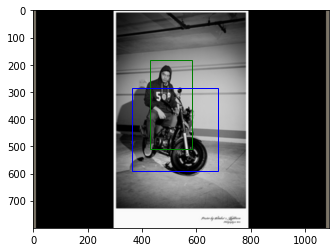

<Figure size 432x288 with 0 Axes>

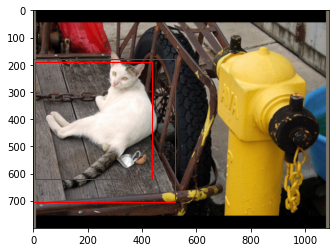

<Figure size 432x288 with 0 Axes>

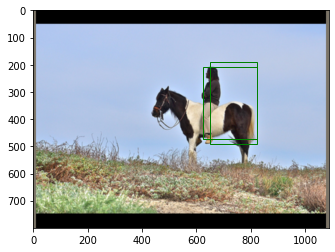

<Figure size 432x288 with 0 Axes>

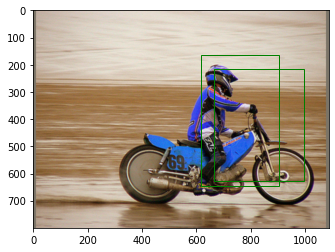

<Figure size 432x288 with 0 Axes>

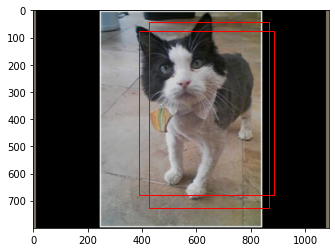

<Figure size 432x288 with 0 Axes>

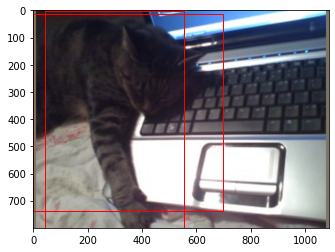

<Figure size 432x288 with 0 Axes>

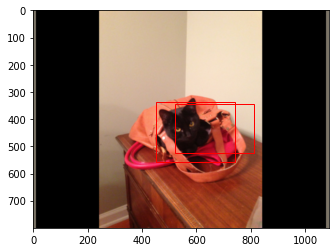

<Figure size 432x288 with 0 Axes>

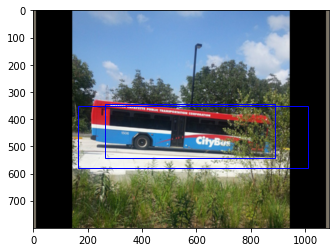

<Figure size 432x288 with 0 Axes>

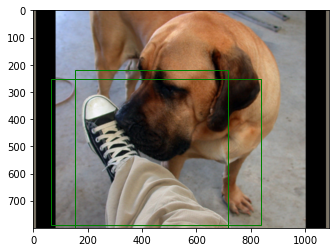

<Figure size 432x288 with 0 Axes>

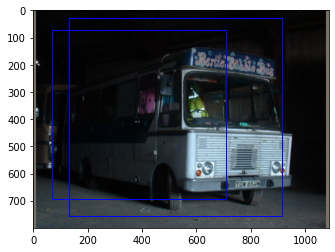

In [18]:
annotations = ["vehicle", "person", "animal"]
idx = [4, 5, 6, 7,11,34,24,25,98,43]

for i, batch in enumerate(test_loader):
  if i in idx:
    images = batch['images'].to(device)
    gt_labels = batch['labels']
    boxes = batch['bboxes']
    backout = backbone(images)

    # The RPN implementation takes as first argument the following image list
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    # Then we pass the image list and the backbone output through the rpn
    rpnout = rpn(im_lis, backout)
    #pdb.set_trace()
    #The final output is
    # A list of proposal tensors: list:len(bz){(keep_topK,4)}
    proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
    fpn_feat_list= list(backout.values())
    feature_vectors=boxHead.MultiScaleRoiAlign(fpn_feat_list.copy(),proposals.copy())
    class_logits,box_preds=boxHead(feature_vectors)
    
    class_gt,class_gt_box = boxHead.create_ground_truth(proposals,gt_labels,boxes)
    
    img = images[0]
    img = transforms.functional.normalize(img,
                    [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    [1/0.229, 1/0.224, 1/0.225], inplace=False)
    img = img.permute(1,2,0).cpu().numpy()
    
   
    class_gt_box = torch.Tensor(class_gt_box)
    proposal_flatten = proposals.copy()
    proposal_flatten = torch.stack(proposal_flatten,dim=0)
    proposal_flatten = proposal_flatten.reshape((-1, proposal_flatten.shape[2]))
    class_gt_box_decoded = output_decoding(class_gt_box,proposal_flatten, device=device)    

    # Do whaterver post processing you find performs best
    boxes,scores,labels=boxHead.postprocess_detections(class_logits,box_preds,proposals,conf_thresh=0.8, keep_num_preNMS=50, keep_num_postNMS=2)
    plt.figure()
    fig, ax = plt.subplots(1,1)
    ax.imshow(img)
    for c, l in zip(boxes[0], labels[0]):
      l = int(l)
      col = ''
      if l == 1:
        col = 'b'
      elif l == 2:
        col = 'g'
      else:
        col = 'r'
      rect=patches.Rectangle((c[0],c[1]),c[2]-c[0],c[3]-c[1],fill=False,color=col)
      ax.add_patch(rect)
    plt.savefig(f"images/p5_{i - 4}")